In [1]:
using Plots

n,p = 1000, 0.51
a,b = 1,1
f = 0.1

function gain(f,n=n, p=p, a=1,b=1)
    gains = cumsum(rand(n).<p)
    trials = 1:n
    fac = ((1 + f*a) / (1 - f*b)).*ones(n) 
    ret = fac.^gains
    return ret .* ( (1 - f*b).^trials )
end


R(f, p, a, b) = (1 + f*a)^p * (1 - f*b)^(1-p)
f_kelly(p,a,b) = p/b - (1-p)/a

f_kelly (generic function with 1 method)

In [21]:
n,N = 100, 20
p,a,b = 0.7,1,1
f_list = 0.02:0.02:0.98

function samples(f,p,a,b)
    A = zeros(n,N)
    for i in 1:N
        A[:,i] = gain(f,n,p,a,b)
    end
    return A
end

D = Dict()
for f in f_list
    D[f] = samples(f,p,a,b)
end

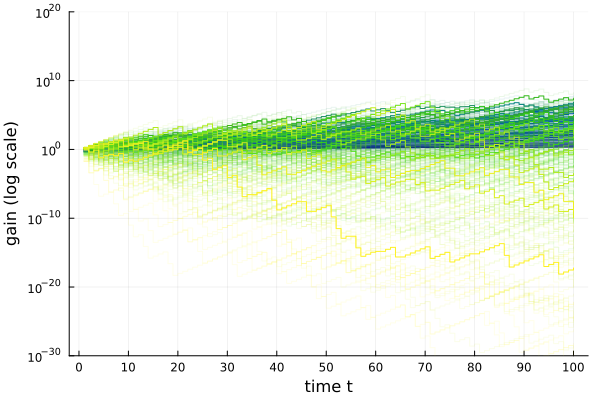

In [22]:
plot(yscale=:log)
cmap = cgrad(:linear_bgy_10_95_c74_n256)

for f in f_list
    plot!(D[f][:,1:10], alpha=0.1, seriestype=:steppost, color=cmap[f],label=:none)
    plot!(sum(D[f],dims=2)/N, color=cmap[f], seriestype=:steppost,cbar=true,label=:none)
end

plot!(
    xlabel="time t", 
    ylabel = "gain (log scale)", 
    xticks=0:10:100,
    colorbar=:best,
    cbar=true)

ylims!((1e-30,1e20))

In [23]:
function mean_floored(v)
    m = sum(v)./size(v)[1]
    ( isnan(m) || m<=1e-30 ) ? 1e-30 : m
end
M = [mean_floored(D[f][end,:]) for f in f_list];
using Statistics
σ = [std(D[f][end,:]) for f in f_list];

In [33]:
using Distributions
P = Binomial(n,p)
qsimple(δ) = quantile(P, 1 - δ)
qmax(m, δ = 0.1) = quantile(P, (1 - δ)^(1/m))
function maxgain(f,m,n,p)
    k = qmax(m)
    ((1 - f)^(n-k)) * (1+f)^k
end
M3 = maxgain.(f_list, N, n, p);

In [39]:
function mean_2(f,n,N,p,a=1,b=1)
    q = qmax(N)
    st = sqrt(n/(q*(n-q))) / sqrt(2*pi) * ((n/(n-q))^n) * (((n-q)/q)^q)   # Stirling's approx of binomial(n,t)
    (((1-p)*(1-f*b))^(n-q)) * ((p*(1 + f*a))^q) * st 
end

M2 = mean_2.(f_list, n,N,p)

49-element Vector{Float64}:
    0.024765936336853155
    0.07751956055074878
    0.23353167299198696
    0.6776048147923044
    1.8948921596267285
    5.109927683913663
   13.294641452014307
   33.38446007321412
   80.9388686413999
  189.50423548349508
    ⋮
 6201.26996507704
 1409.7593747205835
  231.6945127117262
   24.97884536431235
    1.5191741909430985
    0.040477859024484183
    0.0002940917891659726
    2.0091160934845033e-7
    4.316528687807585e-13

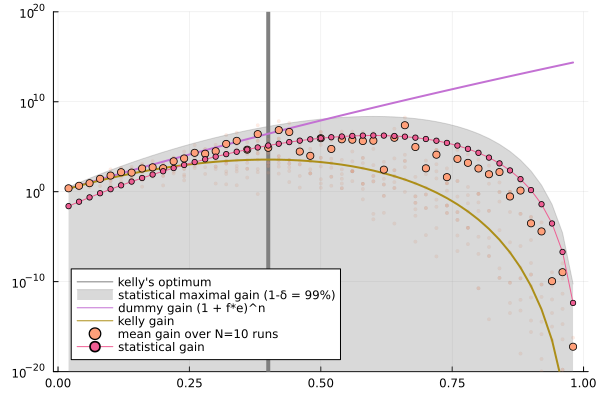

In [40]:
function g(f,p,a,b,n)
    gamma = (1 + f*a) / (1 - f*b)
    (1 - f*b)^n * gamma^(n*p) + 2
end

N_plot = Int(min(N,1000))

vline([f_kelly(p,a,b)], color=:gray, lw=4, label="kelly's optimum")
for f in f_list
    scatter!(f.*ones(N_plot), D[f][end,1:N_plot], color=:lightsalmon, alpha=0.2, ms=2, label=:none, markerstrokewidth=0)
end
plot!(f_list, M3, fillrange=1e-20, label = "statistical maximal gain (1-δ = 99%)", color=:gray, alpha=0.3)
plot!(yscale=:log, ylims=(1e-20, 1e20), legend=:bottomleft)
plot!(ylims=(1e-20,1e20))
e = p*a - (1-p)*b
plot!(f_list, (1 .+ e.*f_list).^n , lw=2, label="dummy gain (1 + f*e)^n")
plot!(f_list, R.(f_list, p,a,b).^n, lw=2, label="kelly gain")

scatter!(f_list, M, color=:lightsalmon, label="mean gain over N=$N runs")
#plot!(f_list, M .+ σ, fillrange = M.-σ, color=:gray, alpha=0.2)
plot!(f_list, M2, markersize=3, markershape=:circle, label="statistical gain")


